<a href="https://colab.research.google.com/github/samnkrki/toxic-comment-classification/blob/main/tc_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d


In [ ]:
!pip install transformers
!pip install googletrans==4.0.0rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.3 MB/s 
     |████████████████████████████████| 163 kB 55.8 MB/s 
     |████████████████████████████████| 7.6 MB 64.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 1.4 MB 55.4 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=3eaf2caf12555cc0c1e60b80d33462fb68fa996231fe93a96c286371dc545933
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


In [ ]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import transformers
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
words = stopwords.words("english")
lemma = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import torch
from transformers import BertTokenizer
from transformers import RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel,RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud , STOPWORDS
from googletrans import * 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_PATH='drive/MyDrive/Colab Notebooks/NLP/'
train = pd.read_csv(INPUT_PATH+"toxic_comment/train.csv", index_col="id")
test = pd.read_csv(INPUT_PATH+"toxic_comment/test.csv", index_col="id")

In [ ]:
train = train.head(5000)
test = test.head(2000)

In [ ]:
train.head(70)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,1,0,1,0,1,0
00290e2a171dd073,"""\n - NeilN's bang on - You aren't being haras...",0,0,0,0,0,0
002918ae66cc4bc2,"I went there around the same time he did, and ...",0,0,0,0,0,0


translator

In [ ]:
# translate dataset to increase dataset count, does not work as this has huge amount of data to translate, 
#problem is translate returns same result in most cases
translator = Translator()

train_obs = train[(train['toxic'] == 1) | (train['severe_toxic'] == 1) | (train['obscene']==1) | (train['threat'] == 1) | (train['insult']==1) | (train['identity_hate']==1)];

train_es = []
train_de = []
train_fr = []

train_es_df = train_obs;
train_de_df = train_obs;
train_fr_df = train_obs;

for i in range(train_obs.comment_text.values):
  print(train_obs.comment_text.values[i])
  encode_es = translator.translate(train_obs.comment_text.values[i] , dest='es').text
  decode_es = translator.translate(encode_es , dest='en').text
  train_es.append(decode_es)

  encode_de = translator.translate(train_obs.comment_text.values[i] , dest='de').text
  decode_de = translator.translate(encode_de , dest='en').text
  train_de.append(decode_de)

  encode_fr = translator.translate(train_obs.comment_text.values[i] , dest='fr').text
  decode_fr = translator.translate(encode_fr , dest='en').text
  train_fr.append(decode_fr)

print(train_obs.head(5));
train_es_df['comment_text'] = train_es
train_de_df['comment_text'] = train_de
train_fr_df['comment_text'] = train_fr

train = pd.concat([train, train_es_df, train_de_df, train_fr_df])

In [ ]:
train.columns
X = train.comment_text.values
y = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.1, random_state=2020)
print(X_train, y_train)

['Yeah! You dummy!  Bakutrix'
 "Nietzsche's Last Man \n\nWas Nietzsche's concept of the Last Man explicitly implied in the title?  The article makes no mention of it per se, though it sounds implied, so I added a link at the end."
 '"\nThnx for d help, i\'m logging in into twitter, if i will give my personal mobile no. to u there, will u call me ri8 now ??\xa0\xa0talk "'
 ...
 '"\nOkay, wasn\'t that easy? So what is WRMEA then? ""Palestinian activism?"" That seems like a rather fair assessment and could be sourced from one of their many publish articles, right?   "'
 '"\n\n""I\'m pretty sure (I wish I could find more history about it) that the the toponym ""River Plate"" is a relative neologism coined in the British Empire (esp. in England) perhaps as little as a century or so ago. "" - You\'re surety is misplaced. The British have been calling it River Plate since Drake. With the barest minimum of research I counter your assertion with the fact that a book entitled ""A narrative of th

Creating word cloud

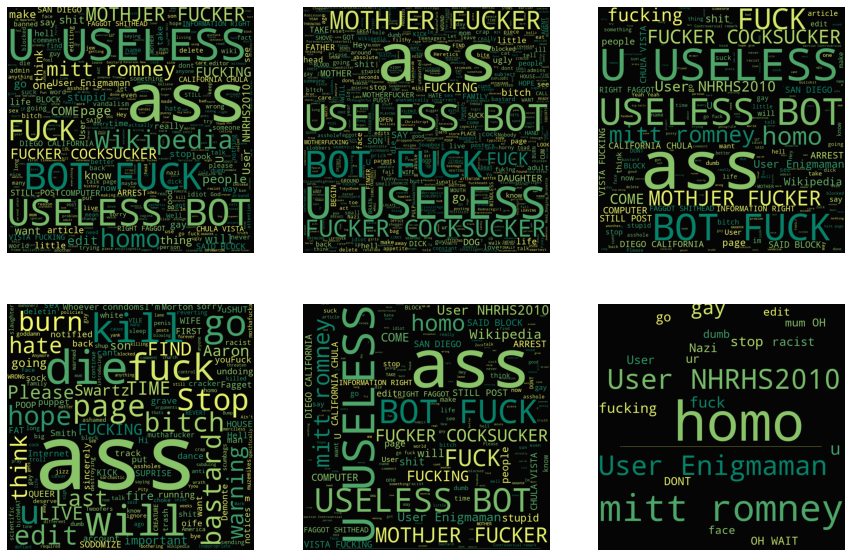

In [ ]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
types = [['toxic',	'severe_toxic',	'obscene',]	,['threat',	'insult',	'identity_hate']]

for r in range(2):
    for c in range(3):
      toxic_data = train[train[types[r][c]]==1]
      str1 = ''.join(toxic_data['comment_text'])
      wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', max_words=2000,
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image
      ax = axes[r][c]                        
      ax.imshow(wordcloud.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)
      ax.axis("off") 

plt.show() 

In [ ]:
# remove unnecessary symbols from text, unknown languages other than english.
import string

latin_words = "’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"

def filtered_text(train_sentences):
    white_list = string.ascii_letters + string.digits + latin_words + ' '
    white_list += "'?!,().\":&-#%^;$^"
    return_str = ''
    for each_sentence in train_sentences:
        for each_word in each_sentence:
            if each_word not in white_list:
                return_str += each_word
    return return_str

symbols_to_remove = filtered_text(X_train)
print(symbols_to_remove)




  















—

















































































</曹操


]]





—







☥

/











```

``

`





|



    



/

/

|



[]



















||=














（）


–—



/





|


/









{{}}













=_=







/

@

/


++
//
/













•



—·[]













/












/

























[[[[









⁄• 








/

[////












==

==/@











~



— 














/Α⇔Ω¦⇒✉







/








||




||












~~~~




//
====··





///=_










/–














/



•







]]







~~~~





//



////=_/==//







__[____]








































_/



//////




/




/















/☯   

/
==



==[[_|]]]]
[[/|





//////













——  
–//////




[////]








[]




















[]

////







/[]



[][][ǖ][][][][ǖ]

[]






{{}}









_•






]]
////_
 


··


























ПочтовыемаркииисторияпочтыАзербайджана**













In [ ]:

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = ''.join(c for c in text if not (c.isnumeric() and c in symbols_to_remove))
    
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # replace = sign
    text = re.sub(r'=','', text)

    # remove ip addresses
    text = re.sub(r"^(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])$", '', text)

    # remove urls
    text = re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', '', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # remove non english characters
    # text = ''.join(c for c in text if not c in symbols_to_remove)

    return text

In [ ]:
temp = train["comment_text"][100]
print(temp)
val = text_preprocessing(text=temp)
print(val)

However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
However, the Moonlite edit noted by golden daph was me (on optus ...) Wake up wikkis. So funny


In [ ]:
#Load the Bert tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base',do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=False)
# Create a funcition to tokenize a set of text

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # create empty lists to store outputs
    input_ids = []
    attention_masks = []
    
    #for every sentence...
    
    for sent in data:
        # 'encode_plus will':
        # (1) Tokenize the sentence
        # (2) Add the `[CLS]` and `[SEP]` token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map tokens to their IDs
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = text_preprocessing(sent),   #preprocess sentence
            add_special_tokens = True,         #Add `[CLS]` and `[SEP]`
            max_length= MAX_LEN,             #Max length to truncate/pad
            pad_to_max_length = True,          #pad sentence to max length 
            return_attention_mask= True        #Return attention mask 
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        
    #convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids,attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
ID = 'id'
DATA_COLUMN = 'comment_text'
LABEL_COLUMNS = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [ ]:
# Before tokenizing we need to specify the maximum length of our sentences

#concat the train data and test data

all_text = np.concatenate([train.comment_text.values,test.comment_text.values])

#Encode the concatenated data
len_sent = [len(text_preprocessing(sent)) for sent in all_text]

# Find the maximum length
avg_len = np.mean(len_sent)
print('Avg length: ',avg_len)

Avg length:  384.8695714285714


In [ ]:
MAX_LEN = 300

# Print sentece 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ',X[0])
print('Token IDs: ',token_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Token IDs:  [101, 100, 100, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 100, 100, 100, 2020, 16407, 1029, 100, 2020, 2025, 3158, 9305, 22556, 1010, 2074, 8503, 2006, 2070, 100, 2044, 100, 5444, 2012, 100, 100, 100, 100, 1012, 100, 3531, 2079, 2025, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 100, 1005, 1049, 3394, 2085, 1012, 6486, 1012, 16327, 1012, 4229, 1012, 2676, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

## For fine-tuning Bert, the authors recommmend a batch size of 16 or 32
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs,train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
# Create the BertClassifier class

class BertClassifier(nn.Module):
    """
        Bert Model for classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param   bert: a BertModel object
        @param   classifier: a torch.nn.Module classifier
        @param   freeze_bert (bool): Set `False` to fine_tune the Bert model
        """
        super(BertClassifier,self).__init__()
        # Specify hidden size of Bert, hidden size of our classifier, and number of labels
        D_in, H,D_out = 768,30,6
        
#         self.bert = RobertaModel.from_pretrained('roberta-base')
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        
        self.classifier = nn.Sequential(
                            nn.Linear(D_in, H),
                            nn.ReLU(),
                            nn.Linear(H, D_out))
        self.sigmoid = nn.Sigmoid()
        # Freeze the Bert Model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self,input_ids,attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        outputs = self.bert(input_ids=input_ids,
                           attention_mask = attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:,0,:]
        
        # Feed input to classifier to compute logits
        logit = self.classifier(last_hidden_state_cls)
        
#         logits = self.sigmoid(logit)
        
        return logit

CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 51 µs


In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    
    bert_classifier.to(device)
    
    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                     lr=5e-5, #Default learning rate
                     eps=1e-8 #Default epsilon value
                     )
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps=0, # Default value
                                              num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# Specify loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    # print(len(train_dataloader))
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        print('training mode')
        model.train()
        print('trained')
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # print(step)
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels.float())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20--50000 batches
            if (step % 50000 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels.float())
        val_loss.append(loss.item())
        print(loss ,'loss')
        # Get the predictions
        #preds = torch.argmax(logits, dim=1).flatten()
        
        # Calculate the accuracy rate
        #accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy = accuracy_thresh(logits.view(-1,6),b_labels.view(-1,6))
        print(accuracy, 'accuracy')
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def accuracy_thresh(y_pred, y_true, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: 
        y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.byte()).float().mean().item()
    #return np.mean(((y_pred>thresh).float()==y_true.float()).float().cpu().numpy(), axis=1).sum()

In [ ]:
set_seed(21)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
training mode
trained
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    #probs = F.softmax(all_logits, dim=1).cpu().numpy()
    probs = all_logits.sigmoid().cpu().numpy()
    

    return probs

#probs = all_logits.sigmoid().cpu().numpy()

In [ ]:
## Compute predicted probabilities on the test set

probs = bert_predict(bert_classifier,val_dataloader)

# Evalueate the bert classifier

# evaluate_roc(probs, y_val)

In [ ]:
probs

array([[0.7976143 , 0.05074827, 0.43180117, 0.0662609 , 0.5379142 ,
        0.06510816],
       [0.04974844, 0.02464263, 0.04388858, 0.02636845, 0.03115027,
        0.01435781],
       [0.8668212 , 0.10493713, 0.6853376 , 0.14683987, 0.6569831 ,
        0.16851348],
       ...,
       [0.04900075, 0.02496909, 0.04422736, 0.02629982, 0.03101907,
        0.01444691],
       [0.05006123, 0.0247036 , 0.04376648, 0.02634516, 0.03104231,
        0.01426082],
       [0.05506492, 0.02325705, 0.04385391, 0.02523391, 0.03132025,
        0.01331176]], dtype=float32)

In [ ]:
# Concatenate the train set and the validation set

full_train_data = torch.utils.data.ConcatDataset([train_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=batch_size)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

625
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
training mode
trained
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230


In [ ]:
test["comment_text"] = test["comment_text"].apply(text_preprocessing)

## Run preprocessing_for_bert on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test.comment_text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
#test_sampler = SequentialSampler(test_dataset)
#test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

Tokenizing data...


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
#threshold = 0.5. ## Change depending on the accuracy you need
#preds = np.where(probs[:, 1] > threshold, 1, 0)

In [ ]:

threshold = 0.5 ## Change depending on the accuracy you need
preds = np.where(probs > threshold, 1, 0)

#preds
preds

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
submission = pd.DataFrame(preds,columns=LABEL_COLUMNS)
submission

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,1,0,1,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1995,1,0,1,0,1,0
1996,0,0,0,0,0,0
1997,0,0,0,0,0,0
1998,0,0,0,0,0,0


In [ ]:
test[LABEL_COLUMNS]=probs
test.to_csv("test_probs.csv",index=False)
test[LABEL_COLUMNS]=preds
test.to_csv("test_preds.csv",index=False)

In [ ]:
final_sub = test[LABEL_COLUMNS]
final_sub.head()
final_sub.to_csv("BertModel_proba.csv",index=False)

In [ ]:
from google.colab import files
files.download("test_preds.csv")
files.download('BertModel_proba.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>